# Toxic Comments Classifier
- Justin Sarenas 304675389
- Henry Ho 304723723
- Nikko DeGuzman 302351054

In [1]:
# import numpy and pandas
import numpy as np
import pandas as pd

# import matplotlib
import matplotlib.pyplot as plt

# import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, GlobalMaxPool1D, Dropout

from keras.models import Model

%matplotlib inline

c:\users\seppc\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Downloading the data

In [2]:
# Downloading training and testing datasets
path = '.\\Datasets\\ToxicComments\\'
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')

In [3]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
# Listing the columns
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = train_df[label_cols]

## Preprocessing

#### Tokenizing the sentences
- Keras tokenizer will split the sentences into individual words. It will take these words and assign an integer to the most frequent 50000 words.

- num_words is the maximun number of words to keep based on the word frequency. Only the most common words will be kept. We use 50000 because it would be too large without a limit

- we assign each of the top 50000 words with a unique key integer like a dictionary

In [6]:
num_words = 50000
# Build the vocabulary with the top 50000 words in train_df and map each word to an index
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_df['comment_text'])

tokenized_train = tokenizer.texts_to_sequences(train_df['comment_text'])
tokenized_test = tokenizer.texts_to_sequences(test_df['comment_text'])

#### Here we can see how the sentence is represented in a list of numbers and what values each of the words represents

In [7]:
print(train_df['comment_text'].iloc[0])
print('\n')
print(tokenized_train[0])
print('\n')
print(tokenizer.word_index['explanation'])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


[688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]


688


#### This is the word dictionary that was built using the training data

In [8]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'wikipedia': 28,
 'my': 29,
 'an': 30,
 'from': 31,
 'by': 32,
 'do': 33,
 'at': 34,
 'me': 35,
 'about': 36,
 'so': 37,
 'talk': 38,
 'what': 39,
 'can': 40,
 'there': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'please': 45,
 'no': 46,
 'would': 47,
 'one': 48,
 'like': 49,
 'just': 50,
 'they': 51,
 'he': 52,
 'which': 53,
 'any': 54,
 'been': 55,
 'should': 56,
 'more': 57,
 'we': 58,
 "don't": 59,
 'some': 60,
 'other': 61,
 'who': 62,
 'here': 63,
 'see': 64,
 'also': 65,
 'his': 66,
 'think': 67,
 'because': 68,
 'know': 69,
 'how': 70,
 'edit': 71,
 'am': 72,
 "i'm": 73,
 'people': 74,
 'why': 75,
 'up': 76,
 'only': 77,
 "it's": 78,
 'out': 79,
 'articles': 80,
 'use': 81,

#### This is how frequent the words have been used

In [9]:
tokenizer.word_counts

OrderedDict([('explanation', 1771),
             ('why', 17818),
             ('the', 496540),
             ('edits', 9957),
             ('made', 9678),
             ('under', 7001),
             ('my', 45619),
             ('username', 1823),
             ('hardcore', 166),
             ('metallica', 35),
             ('fan', 1025),
             ('were', 15421),
             ('reverted', 3902),
             ('they', 27318),
             ("weren't", 424),
             ('vandalisms', 38),
             ('just', 27806),
             ('closure', 88),
             ('on', 89968),
             ('some', 22586),
             ('gas', 331),
             ('after', 8490),
             ('i', 204397),
             ('voted', 302),
             ('at', 39545),
             ('new', 10665),
             ('york', 912),
             ('dolls', 24),
             ('fac', 321),
             ('and', 224192),
             ('please', 29780),
             ("don't", 22917),
             ('remove', 5140),
          

#### To make the feature column consistent we have to find a common max length of words for each comment in the data. Then we fill in the missing words for shorter comments with empty values and delete words for longer comments.

longest comment length: 1401
average comment length: 66.814835
standard deviation of comment length: 99.145399


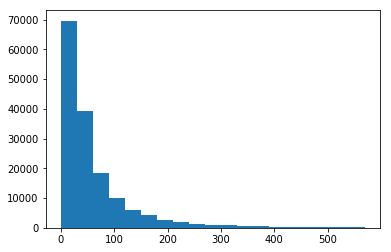

In [10]:
words = [len(comment) for comment in tokenized_train]
print('longest comment length: %d' % max(words))
print('average comment length: %f' % np.mean(words))
print('standard deviation of comment length: %f' % np.std(words))

plt.hist(words, bins=range(0, 600, 30))
plt.show()

#### For the max length of words we chose 300 because that is around 2 standard deviations of the mean

In [11]:
max_length = 300
X_train = pad_sequences(tokenized_train, maxlen=max_length)
X_test = pad_sequences(tokenized_test, maxlen=max_length)

## Creating our LSTM model

#### The input layer is the max amount of words in a comment
#### The embedding layer puts the words in a vector space which will output a 3D tensor

In [12]:
input_size = max_length
hidden_neurons = 64
out_size = 6

# input layer
inp = Input(shape=(input_size,))
# embedding layer
x = Embedding(num_words, 128)(inp)

#### We set our LSTM units to 64 nodes in the hidden layer
#### Then we reduce the dimensionality of the tensor to 2D with GlobalMaxPool1D so we can apply Dropout
#### Dropout will prune some of the nodes so that there is less overfitting and more generalization. 0.1 will dropout 10% of the nodes

In [13]:
# LSTM layer
x = LSTM(hidden_neurons, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)

#### For the recurrent activation we choose ReLU which is a dense layer which will set negative elements to 0 meaning less nodes will be activated thus making it faster
#### After that we apply dropout again

In [14]:
x = Dense(hidden_neurons, activation="relu")(x)
x = Dropout(0.1)(x)

#### Then we feed the output into a sigmoid layer which will do a binary classification of the comments for each of the 6 labels

In [15]:
x = Dense(out_size, activation="sigmoid")(x)

#### Then we create our model which is a binary loss function with the adam optimizer

In [16]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### We will feed 32 comments per gradient update which will run for 2 iterations

In [17]:
batch_size = 32
epochs = 2

fitted_model = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 2716s 19ms/step - loss: 0.0745 - acc: 0.9764 - val_loss: 0.0526 - val_acc: 0.9811
Epoch 2/2
143613/143613 [==============================] - 2816s 20ms/step - loss: 0.0443 - acc: 0.9834 - val_loss: 0.0474 - val_acc: 0.9822


#### Write the model to file and print summary

In [18]:
model.save('lstm_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 128)          6400000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 64)           49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

#### Graphing the progress of the model as it trains

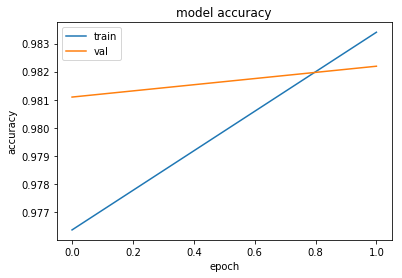

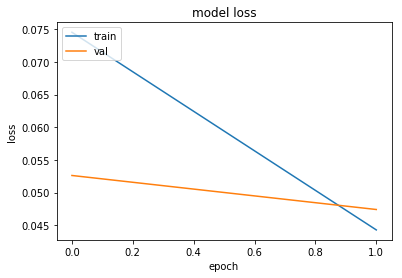

In [19]:
# summarize history for accuracy
plt.plot(fitted_model.history['acc'])
plt.plot(fitted_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Predicting on the testing data

In [20]:
y_test = model.predict(X_test)
y_test

array([[9.9265176e-01, 2.5493041e-01, 9.1121203e-01, 9.3221225e-02,
        8.5141122e-01, 2.4883644e-01],
       [1.1098096e-03, 5.0090426e-07, 6.4085609e-05, 2.0863972e-05,
        6.0883489e-05, 1.6314727e-05],
       [3.7065996e-03, 2.7300348e-06, 3.4126398e-04, 6.4522392e-05,
        2.0398384e-04, 5.0738789e-05],
       ...,
       [2.9866523e-04, 2.4975007e-08, 1.2266046e-05, 1.0448014e-06,
        9.4203133e-06, 2.1930014e-06],
       [4.8545995e-03, 7.0140919e-07, 1.8472485e-04, 2.0032046e-05,
        2.9459095e-04, 6.7483466e-05],
       [9.6461594e-01, 2.7185572e-02, 6.7634869e-01, 1.0673492e-02,
        5.2303737e-01, 4.9488191e-02]], dtype=float32)

#### Writing the testing results to csv

In [21]:
test_df = pd.concat([test_df, pd.DataFrame(columns=label_cols)])
test_df[label_cols] = y_test
test_df = test_df[['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
test_df.to_csv("LSTMOutput.csv", columns=['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], index=False)
test_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.992652,0.25493,0.911212,0.0932212,0.851411,0.248836
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.00110981,5.00904e-07,6.40856e-05,2.0864e-05,6.08835e-05,1.63147e-05
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.0037066,2.73003e-06,0.000341264,6.45224e-05,0.000203984,5.07388e-05
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.00047189,7.29876e-08,2.08067e-05,2.72136e-06,1.64225e-05,4.16793e-06
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.00436186,4.6492e-06,0.000302026,0.000138879,0.00032676,9.85975e-05
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0.00261723,1.53591e-06,0.000135997,5.26853e-05,0.000138879,3.59545e-05
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...,0.00126922,4.22978e-07,6.77469e-05,1.47369e-05,6.71397e-05,2.09785e-05
7,000247e83dcc1211,:Dear god this site is horrible.,0.695151,0.0076431,0.179538,0.0280112,0.242543,0.0610085
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ...",0.0892024,7.71825e-06,0.0036706,0.000113987,0.00817065,0.000714787
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...,0.000339077,5.6673e-08,1.74461e-05,1.9908e-06,1.36728e-05,4.08895e-06
